In [ ]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [1]:
import datetime

In [3]:
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
key = pd.read_csv('../data/key.csv')
test = pd.read_csv('../data/test.csv')
sample = pd.read_csv('../data/sampleSubmission.csv')

### Normality Test

In [ ]:
train.head()

In [ ]:
normtest_df = train.groupby(['store_nbr', 'item_nbr'])
X = train['units']
log_X = np.log(train['units'] + 1)
# normtest_df.tail()

In [ ]:
# Saphiro
result_saphiro_X = scipy.stats.shapiro(X)
result_saphiro_log_X = scipy.stats.shapiro(log_X)
print('test statistic: {}, p-value: {}'.format(result_saphiro_X[0], result_saphiro_X[1]))
print('test statistic: {}, p-value: {}'.format(result_saphiro_log_X[0], result_saphiro_log_X[1]))      

In [ ]:
#KS test
result_ks_X = scipy.stats.kstest(X, cdf='norm')
result_ks_log_X = scipy.stats.kstest(log_X, cdf='norm')
print('test statistic: {}, p-value: {}'.format(result_ks_X[0], result_ks_X[1]))
print('test statistic: {}, p-value: {}'.format(result_ks_log_X[0], result_ks_log_X[1]))

In [ ]:
#Anderson-Darling
result_ad_X = scipy.stats.anderson(X)
result_ad_log_X = scipy.stats.anderson(log_X)
print('test statistic: {}, p-value: {}'.format(result_ad_X[0], result_ad_X[1][2]))
print('test statistic: {}, p-value: {}'.format(result_ad_log_X[0], result_ad_log_X[1][2]))

In [5]:
def TM_transform(series, T_replace, M_replace): 
    """
    데이터내의 T, M을 원하는 값으로 바꿔주는 함수
    TM_transform(series, T_replace, M_replace)
    """
    series = series.astype(str).map(lambda s: s.strip())
    series[series == 'T'] = T_replace
    series[series =='M'] = M_replace
    return series.astype('float')

In [6]:
def match_dateformat(df, year):
    """
    영문 월을 숫자 월로 바꾸어주고 나중에 사용하기 쉽도록 datetime.date 형태로 바꾸어주는 함수
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(len(df)):
        dates = df.loc[i][0]
        dates = dates.split(" ")
        for j in range(len(months)):
            if dates[0] == months[j]:
                dates[0] = str(j + 1)
                dates_df = ["{} {} {}".format(year, dates[0], dates[1])]
                dates_df = pd.to_datetime(dates_df)
                df.loc[i][0] = dates_df.date[0]
    return df

In [7]:
def merge_holiday(holiday_df1, holiday_df2, holiday_df3):
    """
    각 연도별 공휴일 리스트 합치기
    """
    frame = [holiday_df1, holiday_df2, holiday_df3]
    holiday = pd.concat(frame).reset_index(drop=True)
    return holiday

In [8]:
def find_holiday(file, year):
    """
    수요에 영향을 미치는 주요 공휴일을 찾아내는 함수
    """
    holidays = ["New Year's Day", "Martin Luther King Jr. Day", "Valentine's Day",  "President's Day", "Easter Sunday", 
                      "Mother's Day", "Memorial Day", "Father's Day", "Independence Day", "Labor Day", "Columbus Day",
                      "Halloween", "Veterans Day", "Thanksgiving Day", "Black Friday", "Christmas Eve", "Christmas Day", "New Year's Eve"]
    
    holi = pd.read_excel(file, year, header=None)
    holi = match_dateformat(holi, year)
    holiday = pd.DataFrame(columns=[0,1,2,3,4])
    for _ in holidays:
        for i in range(len(holi[2])):
            if _ == holi[2][i]:
                holiday = holiday.append(holi.loc[i])
    return holiday

In [9]:
def cs_preprocessing(codesum):
    codesum_temp = []
    for _ in codesum:
        _ = _.replace('+', '')
        _ = _.replace('-', '')
        if len(_) > 2:
            _1 = _[:2]
            codesum_temp.append(_1)
            _2 = _[2:]
            codesum_temp.append(_2)
        else:
            codesum_temp.append(_)
    codesum = codesum_temp
    return codesum
            

In [10]:
def weather_flagger(weather):
    codesum_ls = ['FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL', 'IC', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS', 'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR', 'BC', 'BL', 'VC']
    weather['date'] = pd.to_datetime(weather['date']) #weather는 글로벌변수
    for i in range(len(weather['codesum'])):
        codesum = weather['codesum'][i].split(" ")
        codesum = cs_preprocessing(codesum)
        for _ in codesum:
            flag = any(code in _ for code in codesum_ls)
            if flag == True:
                weather.set_value(i, '{}_flag'.format(_), 1)
            else:
                weather.set_value(i, 'normal_flag', 1)

    # return x or y depending on the condition
    # "For the purposes of this competition, we have defined a weather event as any day in which more than an inch of rain or two inches of snow was observed."
    # weather_event =  (((codesum contains SN) and (snowfall > 2)) or ((codesum contains RA) and (preciptotal > 1)))
    weather['preciptotal'] = TM_transform(weather['preciptotal'], 0.005, 0.00)
    weather['snowfall'] = TM_transform(weather['snowfall'], 0.005, 0.00)
    weather['snow_event'] = np.where(np.where(weather['SN_flag'] == 1, 1, 0) + np.where(weather['snowfall'] > 2, 1, 0) == 2, 1, 0)
    weather['rain_event'] = np.where(np.where(weather['RA_flag'] == 1, 1, 0) + np.where(weather['preciptotal'] > 1, 1, 0) == 2, 1, 0)
    weather['event'] = weather['snow_event'] + weather['rain_event']
    weather['event'] = np.where(weather['event'] >= 1, 1, 0)
    #    weather['preciptotal_flag'] = np.where(weather['preciptotal'] > 0.2, 1, 0)
    #     weather['depart'] = TM_transform(weather['depart'], np.nan, 0.00)
    #     weather['depart_flag'] = np.where(weather['depart'] > 8.0, 1, 0)
    #     weather['depart_flag'] = np.where(weather['depart'] < 8.0, -1, 0)
    return weather

In [11]:
def test_preprocessing(df, holiday, weather):
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df.date.dt.weekday  # 월요일이 0 일요일이 6
    df['weekend'] = df.date.dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

    df['holiday'] = df.date.isin(holiday[0])
    df['weekday_holiday'] = df.holiday & (df.weekend == False)
    df['weekend_holiday'] = df.holiday & df.weekend
    
    df = pd.merge(df, key, on='store_nbr') #key는 글로벌 변수
    df = pd.merge(df, weather[['date', 'station_nbr', 'RA_flag', 'SN_flag', 'normal_flag', 'event']], on=['date', 'station_nbr'])
    return df

In [12]:
def preprocessing(df, holiday, weather):
    """
    train데이터를 가공하는 함수
    """
    df['units'] = np.log(df['units'] + 1)
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df.date.dt.weekday  # 월요일이 0 일요일이 6
    df['weekend'] = df.date.dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

    df['holiday'] = df.date.isin(holiday[0])
    df['weekday_holiday'] = df.holiday & (df.weekend == False)
    df['weekend_holiday'] = df.holiday & df.weekend
    
    df = pd.merge(df, key, on='store_nbr') #key는 글로벌 변수
    df = pd.merge(df, weather[['date', 'station_nbr', 'RA_flag', 'SN_flag', 'normal_flag', 'event']], on=['date', 'station_nbr'])
    return df

In [13]:
holiday12 = find_holiday('../data/holiday.xlsx', '2012')
holiday13 = find_holiday('../data/holiday.xlsx', '2013')
holiday14 = find_holiday('../data/holiday.xlsx', '2014')
holiday = merge_holiday(holiday12, holiday13, holiday14)
weather = weather_flagger(weather)
processed_train = preprocessing(train, holiday, weather)
processed_test = test_preprocessing(test, holiday, weather)

In [14]:
event_pivot_station_train = processed_train.pivot_table(values='event', index='date', columns='station_nbr')
event_pivot_station_test = processed_test.pivot_table(values='event', index='date', columns='station_nbr')
event_pivot_store_train = processed_train.pivot_table(values='event', index='date', columns='store_nbr')
event_pivot_store_test = processed_test.pivot_table(values='event', index='date', columns='store_nbr')
event_pivot_station_train = pd.DataFrame(event_pivot_station_train.to_records())
event_pivot_station_test = pd.DataFrame(event_pivot_station_test.to_records())
event_pivot_store_train = pd.DataFrame(event_pivot_store_train.to_records())
event_pivot_store_test = pd.DataFrame(event_pivot_store_test.to_records())

## Weather Event by Station

In [19]:
event_pivot_station_train.at[0,'date']

Timestamp('2012-01-01 00:00:00')

In [106]:
event_pivot_station_train.fillna(-1, inplace = True)

In [105]:
event_pivot_station_test.fillna(-1, inplace = True)

In [107]:
event_pivot_station_test['5'] = 0.0
event_pivot_station_test

,date,1,2,3,4,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,5
0,2013-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-04-02,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-04-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2013-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2013-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2013-04-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2013-04-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2013-04-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,2013-04-10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
# for num in range(len(event_pivot_station_train)) :
#     tmp = str(event_pivot_station_train.at[num, 'date'])
# tmp

tmp1 = [str(event_pivot_station_train.at[num, 'date'])for num in range(len(event_pivot_station_train))]
tmp2 = [str(event_pivot_station_test.at[num, 'date'])for num in range(len(event_pivot_station_test))]
xt = ['2012-01', '2012-07', '2013-01', '2013-07', '2014-01', '2014-07']
xi = [i for i in range(len(xt))]

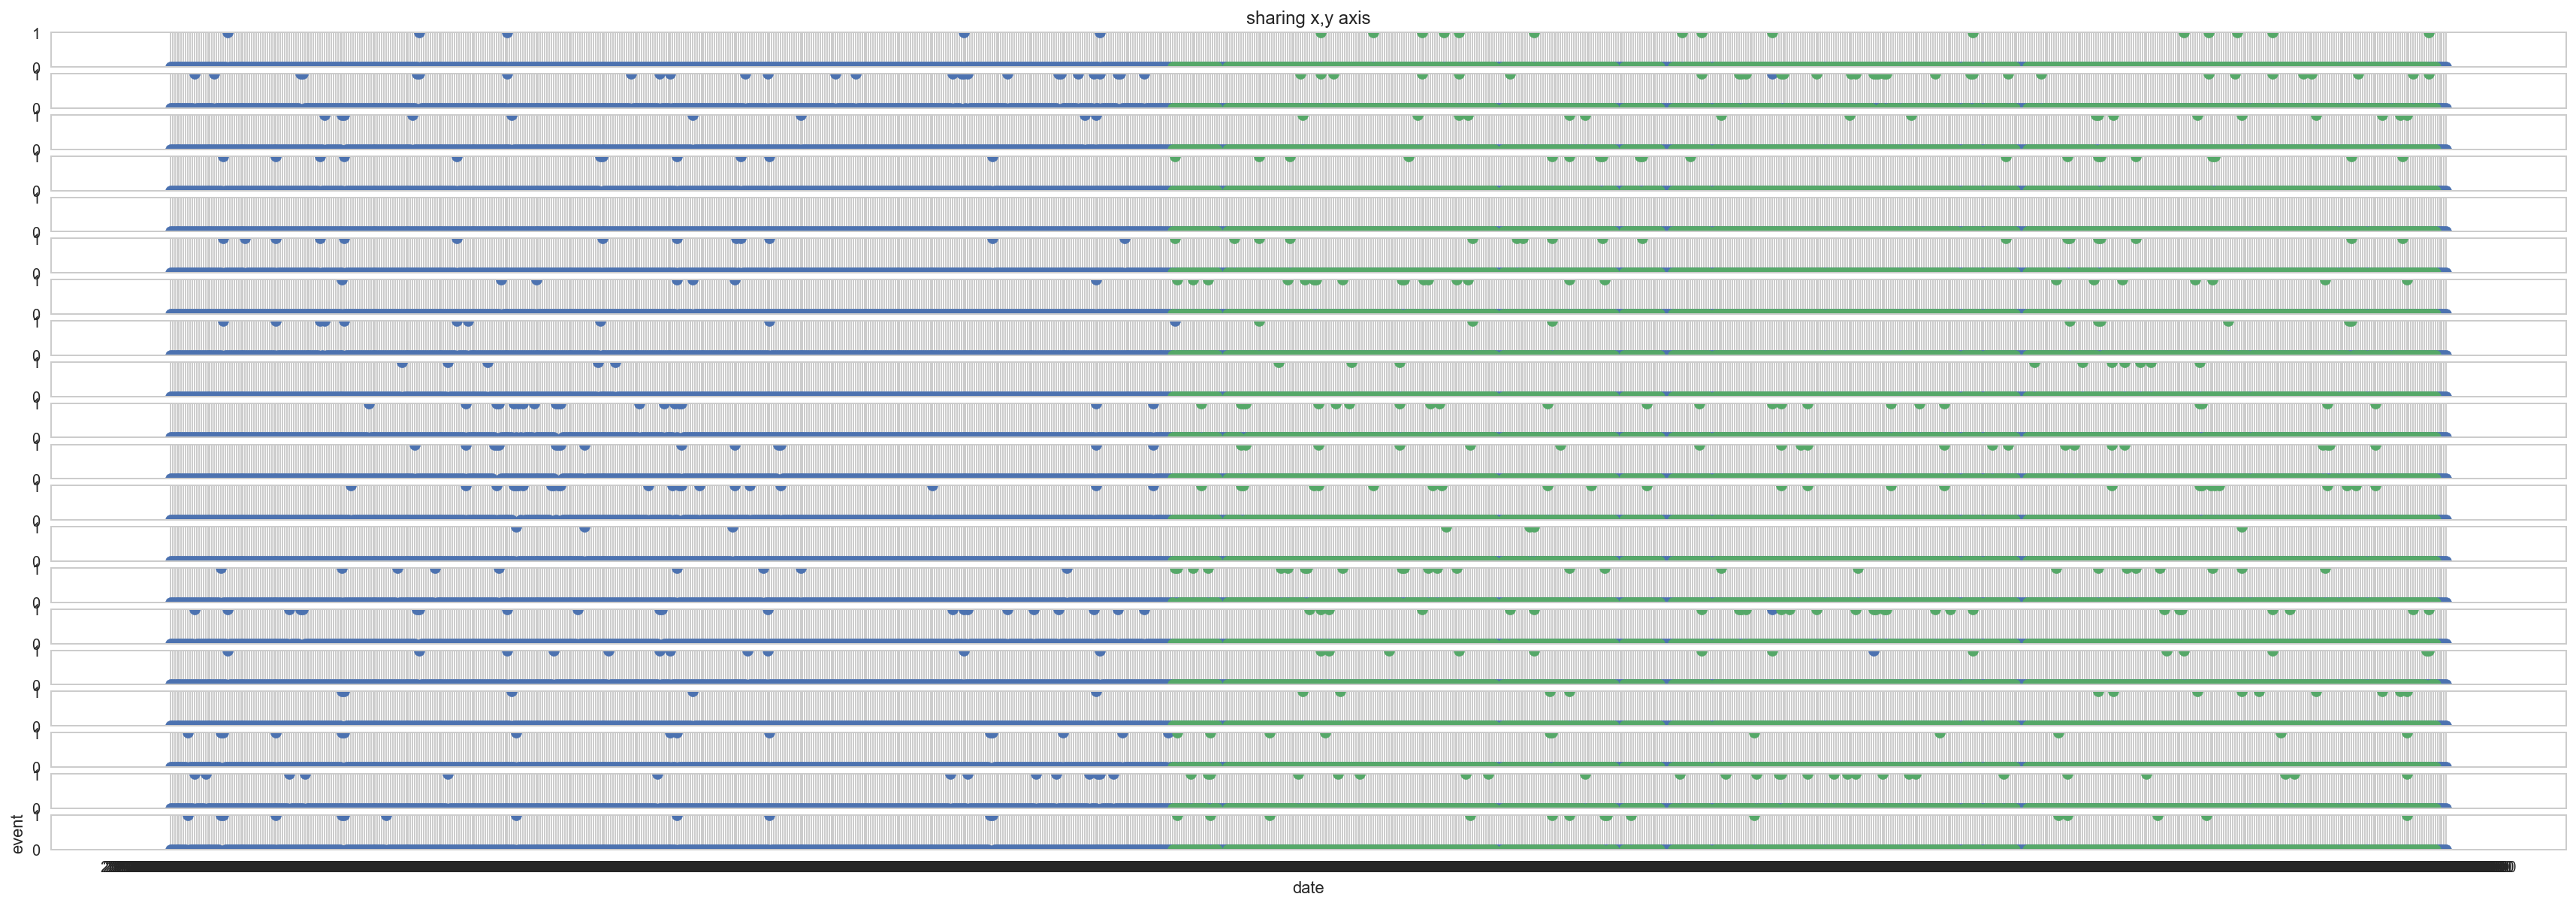

In [109]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20) = plt.subplots(20, sharex = True, sharey = True, figsize = (30, 10))
# plt.figure(figsize = (30, 20))


plt.xlabel('date')
plt.ylabel('event')

# plt.xticks(xi, xt)

plt.ylim(0, 1)

ax1.scatter(tmp1, event_pivot_station_train[str(1)])
ax1.scatter(tmp2, event_pivot_station_test[str(1)])
ax1.set_title("sharing x,y axis")

ax2.scatter(tmp1, event_pivot_station_train[str(2)])
ax2.scatter(tmp2, event_pivot_station_test[str(2)])

ax3.scatter(tmp1, event_pivot_station_train[str(3)])
ax3.scatter(tmp2, event_pivot_station_test[str(3)])

ax4.scatter(tmp1, event_pivot_station_train[str(4)])
ax4.scatter(tmp2, event_pivot_station_test[str(4)])

ax5.scatter(tmp1, event_pivot_station_train[str(5)])
ax5.scatter(tmp2, event_pivot_station_test[str(5)])

ax6.scatter(tmp1, event_pivot_station_train[str(6)])
ax6.scatter(tmp2, event_pivot_station_test[str(6)])

ax7.scatter(tmp1, event_pivot_station_train[str(7)])
ax7.scatter(tmp2, event_pivot_station_test[str(7)])

ax8.scatter(tmp1, event_pivot_station_train[str(8)])
ax8.scatter(tmp2, event_pivot_station_test[str(8)])

ax9.scatter(tmp1, event_pivot_station_train[str(9)])
ax9.scatter(tmp2, event_pivot_station_test[str(9)])

ax10.scatter(tmp1, event_pivot_station_train[str(10)])
ax10.scatter(tmp2, event_pivot_station_test[str(10)])

ax11.scatter(tmp1, event_pivot_station_train[str(11)])
ax11.scatter(tmp2, event_pivot_station_test[str(11)])

ax12.scatter(tmp1, event_pivot_station_train[str(12)])
ax12.scatter(tmp2, event_pivot_station_test[str(12)])

ax13.scatter(tmp1, event_pivot_station_train[str(13)])
ax13.scatter(tmp2, event_pivot_station_test[str(13)])

ax14.scatter(tmp1, event_pivot_station_train[str(14)])
ax14.scatter(tmp2, event_pivot_station_test[str(14)])

ax15.scatter(tmp1, event_pivot_station_train[str(15)])
ax15.scatter(tmp2, event_pivot_station_test[str(15)])

ax16.scatter(tmp1, event_pivot_station_train[str(16)])
ax16.scatter(tmp2, event_pivot_station_test[str(16)])

ax17.scatter(tmp1, event_pivot_station_train[str(17)])
ax17.scatter(tmp2, event_pivot_station_test[str(17)])

ax18.scatter(tmp1, event_pivot_station_train[str(18)])
ax18.scatter(tmp2, event_pivot_station_test[str(18)])

ax19.scatter(tmp1, event_pivot_station_train[str(19)])
ax19.scatter(tmp2, event_pivot_station_test[str(19)])

ax20.scatter(tmp1, event_pivot_station_train[str(20)])
ax20.scatter(tmp2, event_pivot_station_test[str(20)])

# f.subplots_adjust(hspace = 1) 
# plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible = False)

In [27]:
plt.figure(figsize = (30, 20))
# plt.subplots(sharex = True)
for i in ls :
    plt.subplot(20, 1, i)
    plt.scatter(x = tmp1, y = event_pivot_station_train[str(i)])
    plt.scatter(x = tmp2, y = event_pivot_station_test[str(i)])
plt.show()

TypeError: cannot create weak reference to 'bool' object

KeyError: "['2012-01-01 00:00:00' '2012-01-02 00:00:00' '2012-01-03 00:00:00' ...,\n '2014-10-29 00:00:00' '2014-10-30 00:00:00' '2014-10-31 00:00:00'] not in index"

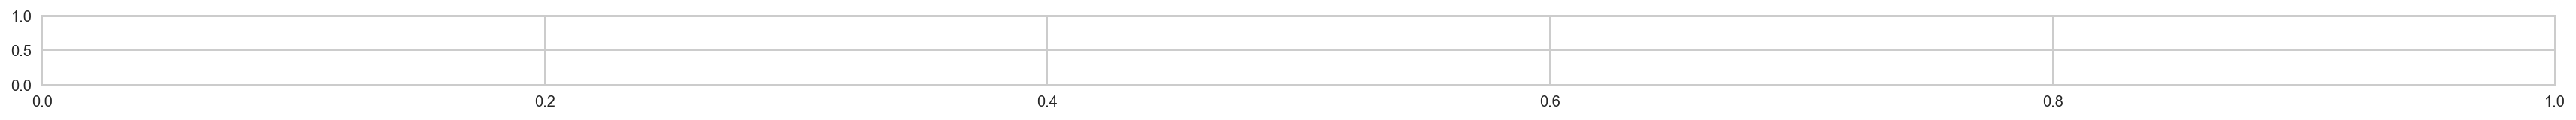

In [34]:
plt.figure(figsize = (30, 20))
for i in range(1, 2):
    plt.subplot(20, 1, i)
    event_pivot_station_train.plot(kind = 'scatter', x = tmp1, y = event_pivot_station_train[str(i)])
    event_pivot_station_test.plot(kind = 'scatter', x = 'date', y = event_pivot_station_test[str(i)])
#     plt.ylim(0, 2)
    plt.xlabel('date') # X 라벨
    plt.ylabel('{}'.format(i))   # Y 라벨 
# x_tick_location = pd.date_range(np.min(event_pivot['date']),np.max(event_pivot['date']), freq='Q-JUL')
# x_tick_labels = [xi for xi in x_tick_location]
# plt.xticks(event_pivot['date'], rotation=45)
plt.title('event occurance') # 제목추가
plt.show()

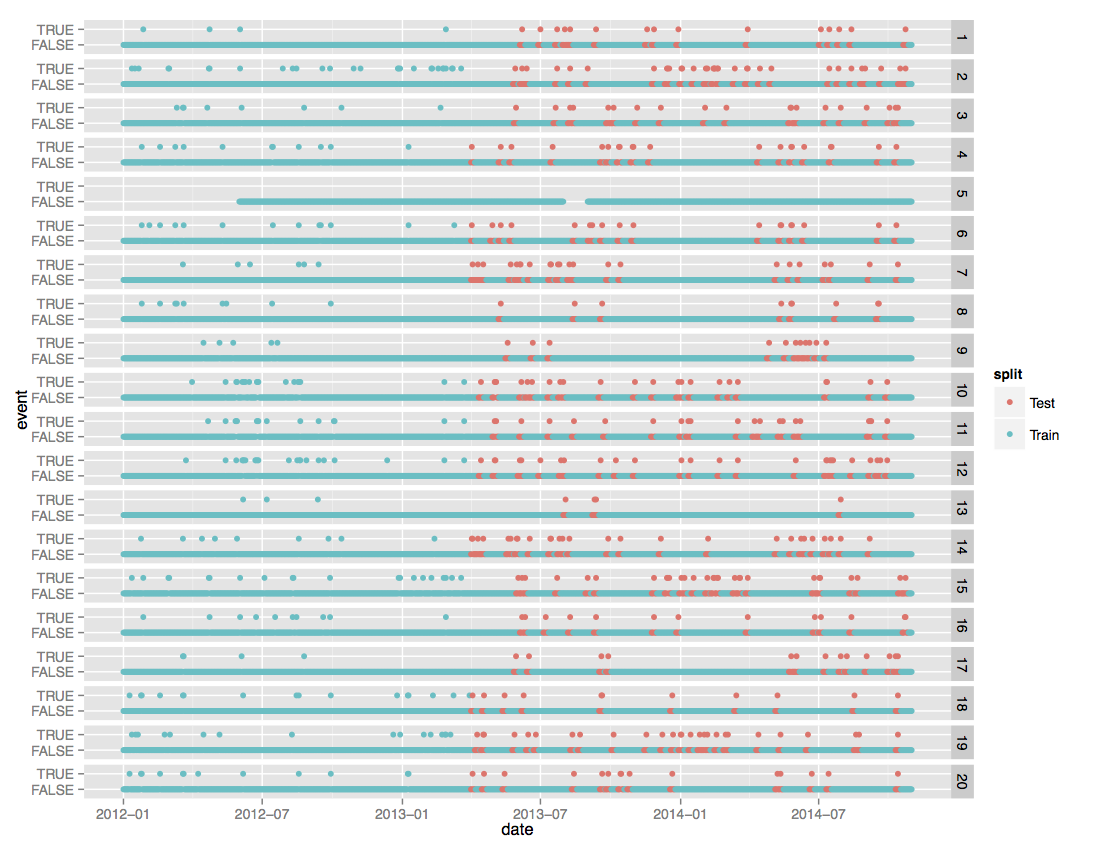

## Weather Event by Store

In [ ]:
plt.figure(figsize = (30, 20))
for i in range(1, 46):
    plt.subplot(45, 1, i)
    sns.stripplot(x='date', y=event_pivot_store[str(i)], data=event_pivot_store)
    plt.ylim(0, 2)
    plt.xlabel('date') # X 라벨
    plt.ylabel('event')   # Y 라벨 
# x_tick_location = pd.date_range(np.min(event_pivot['date']),np.max(event_pivot['date']), freq='Q-JUL')
# x_tick_labels = [xi for xi in x_tick_location]
# plt.xticks(event_pivot['date'], rotation=45)
plt.title('event occurance') # 제목추가
plt.show()

In [ ]:
train_pivot = train.pivot_table(values='units', index=['date'], columns=['station_nbr','store_nbr','item_nbr'], aggfunc=np.sum)